In [1]:
import os
import sys
import cv2
import torch

import numpy as np
import albumentations as album
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from torchmetrics import JaccardIndex

sys.path.insert(0, '..')
from loaders.datasets import AmsterdamDataset
from utils.general import visualize
from utils.augmentation import *
from utils.metrics import BlobOverlap

In [2]:
preprocessing_fn = smp.encoders.get_preprocessing_fn('efficientnet-b3', 'imagenet')
model = torch.load(os.path.join('..', 'experiments', 'effnetb3-unetpp-1000s-aug', 'best_model.pth'))

images = os.path.join('..', 'data', 'images')
annotations = os.path.join('..', 'data', 'fences-quays', 'annotations', 'test-annotations-6px.json')

data = AmsterdamDataset(images, annotations, preprocessing=get_preprocessing(None), train=True)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [3]:
%matplotlib inline

miou = 0
IoU = JaccardIndex(num_classes=2, reduction='none', absent_score=1)
BO = BlobOverlap()

for i, (image, mask) in enumerate(data):
    print(i)
    img = plt.imread(os.path.join(images, data.images[i]['file_name']))
    
    print(data.images[i]['file_name'])
    
    mask = np.squeeze(mask)
    x = torch.as_tensor(image).unsqueeze(0).cuda()
    
    with torch.no_grad():
        pred = model(x)
    
#     visualize(image=img,
#               prediction=pred.squeeze().cpu(),
#               target=mask)
    
    iou = IoU(pred.cpu(), torch.as_tensor(mask).unsqueeze(0).int())

    print('blob-iou:', BO.update(pred, torch.as_tensor(mask).unsqueeze(0)))
    print('iou:', iou)
    
    miou += iou
    
    print()
    
#     if i > 5:
#         break
    
print(miou / (i + 1))
BO.compute()

0
2021-01-26-TMX7316010203-001984-pano_0000_000422-l.jpg
blob-iou: 0.8717948717948718
iou: tensor([0.9899, 0.6470])

1
2021-01-25-TMX7316010203-001979-pano_0001_000055-r.jpg
blob-iou: 0.03191631426663699
iou: tensor([0.9851, 0.0979])

2
2021-01-25-TMX7316010203-001979-pano_0001_000053-l.jpg
blob-iou: 0.8768414631892202
iou: tensor([0.9921, 0.6989])

3
2021-01-22-TMX7316010203-001975-pano_0000_001361-r.jpg
blob-iou: 0.4156798551128448
iou: tensor([0.9444, 0.1867])

4
2021-01-22-TMX7316010203-001975-pano_0000_000028-l.jpg
blob-iou: 0.9174557939143704
iou: tensor([0.9859, 0.5943])

5
2021-01-26-TMX7316010203-001984-pano_0000_000213-r.jpg
blob-iou: 0.34073647871116225
iou: tensor([0.9759, 0.3817])

6
2021-01-26-TMX7316010203-001983-pano_0001_000162-r.jpg
blob-iou: 0.8031585789918863
iou: tensor([0.8264, 0.3229])

7
2021-01-26-TMX7316010203-001983-pano_0001_000087-r.jpg
blob-iou: 0.5278306878306879
iou: tensor([0.9962, 0.4002])

8
2021-01-26-TMX7316010203-001983-pano_0001_000036-r.jpg
blob-

blob-iou: 0.9862561007058195
iou: tensor([0.9915, 0.8096])

70
2021-01-26-TMX7316010203-001982-pano_0000_000612-l.jpg
blob-iou: 0.9716584874525855
iou: tensor([0.9925, 0.8243])

71
2021-01-26-TMX7316010203-001982-pano_0000_000608-l.jpg
blob-iou: 0.7813851395623116
iou: tensor([0.9878, 0.6388])

72
2021-01-26-TMX7316010203-001982-pano_0000_000600-r.jpg
blob-iou: 0.8160316521368102
iou: tensor([0.9625, 0.4484])

73
2021-01-26-TMX7316010203-001982-pano_0000_000585-r.jpg
blob-iou: 0.6984090648964175
iou: tensor([0.9847, 0.5707])

74
2021-01-26-TMX7316010203-001982-pano_0000_000584-r.jpg
blob-iou: 0.9067908742198046
iou: tensor([0.9916, 0.7674])

75
2021-01-22-TMX7316010203-001975-pano_0000_001364-r.jpg
blob-iou: 0.7779885562701461
iou: tensor([0.9867, 0.5958])

76
2021-01-22-TMX7316010203-001975-pano_0000_001359-r.jpg
blob-iou: 0.3792995622263915
iou: tensor([0.9899, 0.4025])

77
2021-01-22-TMX7316010203-001975-pano_0000_000033-l.jpg
blob-iou: 0.762280937224374
iou: tensor([0.9946, 0.6989]

0.7273792794309618

TP: 5408
TN: 506581
FP: 3897
FN: 8402
[-2. -1.  0.  1.]


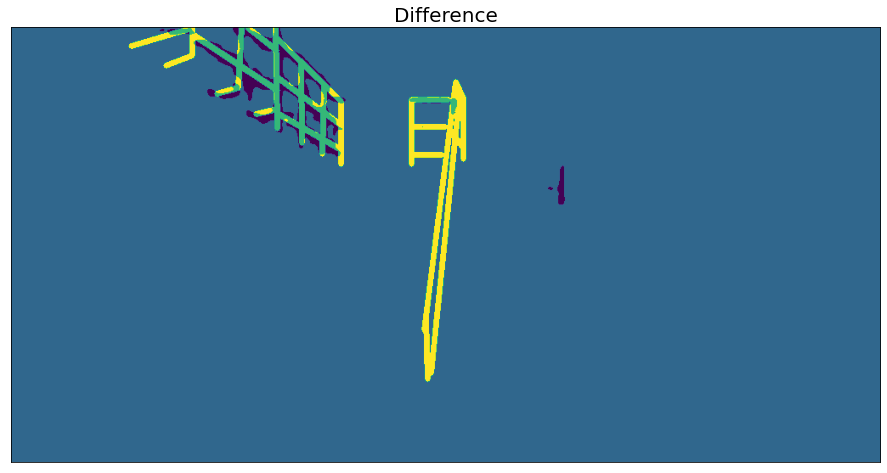

In [4]:
prediction = pred.squeeze().cpu().numpy() > .5
target = mask.copy()

target[np.where(target == 0)] = -1
diff = target - prediction

# 0 = TP / TN
# -1 = FP
# 1 = FN
print('TP:', np.count_nonzero(diff == 0))
print('TN:', np.count_nonzero(diff == -1))
print('FP:', np.count_nonzero(diff == -2))
print('FN:', np.count_nonzero(diff == 1))



print(np.unique(diff))

visualize(difference=diff)

In [5]:
from utils.metrics import PositiveConfusionMatrix

pcm = PositiveConfusionMatrix()

print(pcm(pred.squeeze().cpu(), torch.as_tensor(mask)))

ImportError: cannot import name 'PositiveConfusionMatrix' from 'utils.metrics' (C:\Users\Jorrit\Desktop\projects\msc-thesis-2022\fence-detection\notebooks\..\utils\metrics.py)

In [ ]:
from torchmetrics import ConfusionMatrix

cm = ConfusionMatrix(num_classes=2, normalize='true')

print(np.unique(mask))
mask[mask == -1] = 0

print(cm(pred.squeeze().cpu(), torch.as_tensor(mask).int()))

In [ ]:
# TN FP
# FN TP